In [1]:
import torch
import matplotlib.pyplot as plt
import h5py
import numpy as np
import itertools
import math

In [2]:
class DataProcessor():
    def __init__(self, particle_one, particle_two):
        super(DataProcessor,self).__init__()
        self.CLASS_ONE = particle_one
        self.CLASS_TWO = particle_two
        self.c1 = h5py.File('/fast_scratch_1/QVAE/data/calo/'+self.CLASS_ONE+'.hdf5', 'r')
        self.c2 = h5py.File('/fast_scratch_1/QVAE/data/calo/'+self.CLASS_TWO+'.hdf5', 'r') 


        self.gen_one = 'gen_'+particle_one
        self.gen_two = 'gen_'+particle_two
        self.gen_piplus = '/home/blazerjia/saved_output/RBM/piplus/18-13-51/synthetic_images_piplus.pt'
        self.gen_gamma = '/home/blazerjia/saved_output/unified/synthetic_images_gamma.pt'
        self.gen_eplus = '/home/blazerjia/saved_output/unified/synthetic_images_eplus.pt'
        self.gen_dict = {
            'gen_piplus': self.gen_piplus,
            'gen_gamma': self.gen_gamma,
            'gen_eplus': self.gen_eplus
        }
        
        
    def flattened_class_data(self, class_num):
        c_layer_0 = torch.tensor(np.array(class_num['layer_0']))
        c_layer_1 = torch.tensor(np.array(class_num['layer_1']))
        c_layer_2 = torch.tensor(np.array(class_num['layer_2']))
        c_flatten_0 = torch.flatten(c_layer_0, start_dim=1)
        c_flatten_1 = torch.flatten(c_layer_1, start_dim=1)
        c_flatten_2 = torch.flatten(c_layer_2, start_dim=1)
        flat_class_data = torch.cat((c_flatten_0,c_flatten_1,c_flatten_2), dim=1)
        return flat_class_data
    
    def get_synthetic_dataset(self):
        c1_dir = self.gen_dict[self.gen_one]
        c2_dir = self.gen_dict[self.gen_two]
        gen_c1_data = torch.load(c1_dir)
        gen_c2_data = torch.load(c2_dir)
        gen_c1_tensor = torch.cat(gen_c1_data).cpu()
        gen_c2_tensor = torch.cat(gen_c2_data).cpu()
        print(gen_c1_tensor.size(0))
        return gen_c1_tensor, gen_c2_tensor
          
    def get_geant_dataset(self):
        class_one_data = self.flattened_class_data(self.c1)
        class_two_data = self.flattened_class_data(self.c2)
        return class_one_data, class_two_data

In [3]:
dataloader =  DataProcessor('gamma', 'eplus')
gamma_syn, eplus_syn = dataloader.get_synthetic_dataset()
gamma_geant, eplus_geant = dataloader.get_geant_dataset()

51200


In [4]:
def sort_index(gamma_picked):
    for i in range(gamma_picked.shape[0]):
            sorted_order = torch.argsort(gamma_picked[i])
            for j, value in enumerate(sorted_order):
                gamma_picked[i][value] = j
    return gamma_picked
def interger_tensor(t):
    t_rounded = torch.round(t)
    t_int = t_rounded.int()
    return t_int

In [5]:
def plot_orientation_diff(gamma_syn, eplus_syn, picked_list, data, ax):
    gamma_picked = gamma_syn[:,picked_list]
    eplus_picked = eplus_syn[:,picked_list]
    gamma_picked_index = sort_index(gamma_picked)
    eplus_picked_index = sort_index(eplus_picked)
    gamma_picked_index = interger_tensor(gamma_picked_index)
    eplus_picked_index = interger_tensor(eplus_picked_index)

    sequence = np.linspace(0,len(picked_list)-1,len(picked_list),dtype=int)
    permutations = list(itertools.permutations(sequence))
    mapping = {permutation: index+1 for index, permutation in enumerate(permutations)}

    eplus_list =[]
    for row in eplus_picked_index:
        eplus_list.append(mapping[tuple(row.numpy())])

    gamma_list =[]
    for row in gamma_picked_index:
        gamma_list.append(mapping[tuple(row.numpy())])

    ax.hist(eplus_list, bins = np.arange(1, math.factorial(len(picked_list))+2,1), log = False, alpha = 0.7, label= 'eplus')
    ax.hist(gamma_list, bins = np.arange(1,math.factorial(len(picked_list))+2,1), log = False, alpha = 0.7, label= 'gamma')
    ax.set_title(f'{data} Distribution at {picked_list}')
    ax.set_xlabel('order index')
    ax.legend()

In [6]:
picked_lists = [[141, 142, 143, 144],[340, 341, 342, 343],[352, 353, 354, 355],[364, 365, 366, 367],[376, 377, 378, 379]]

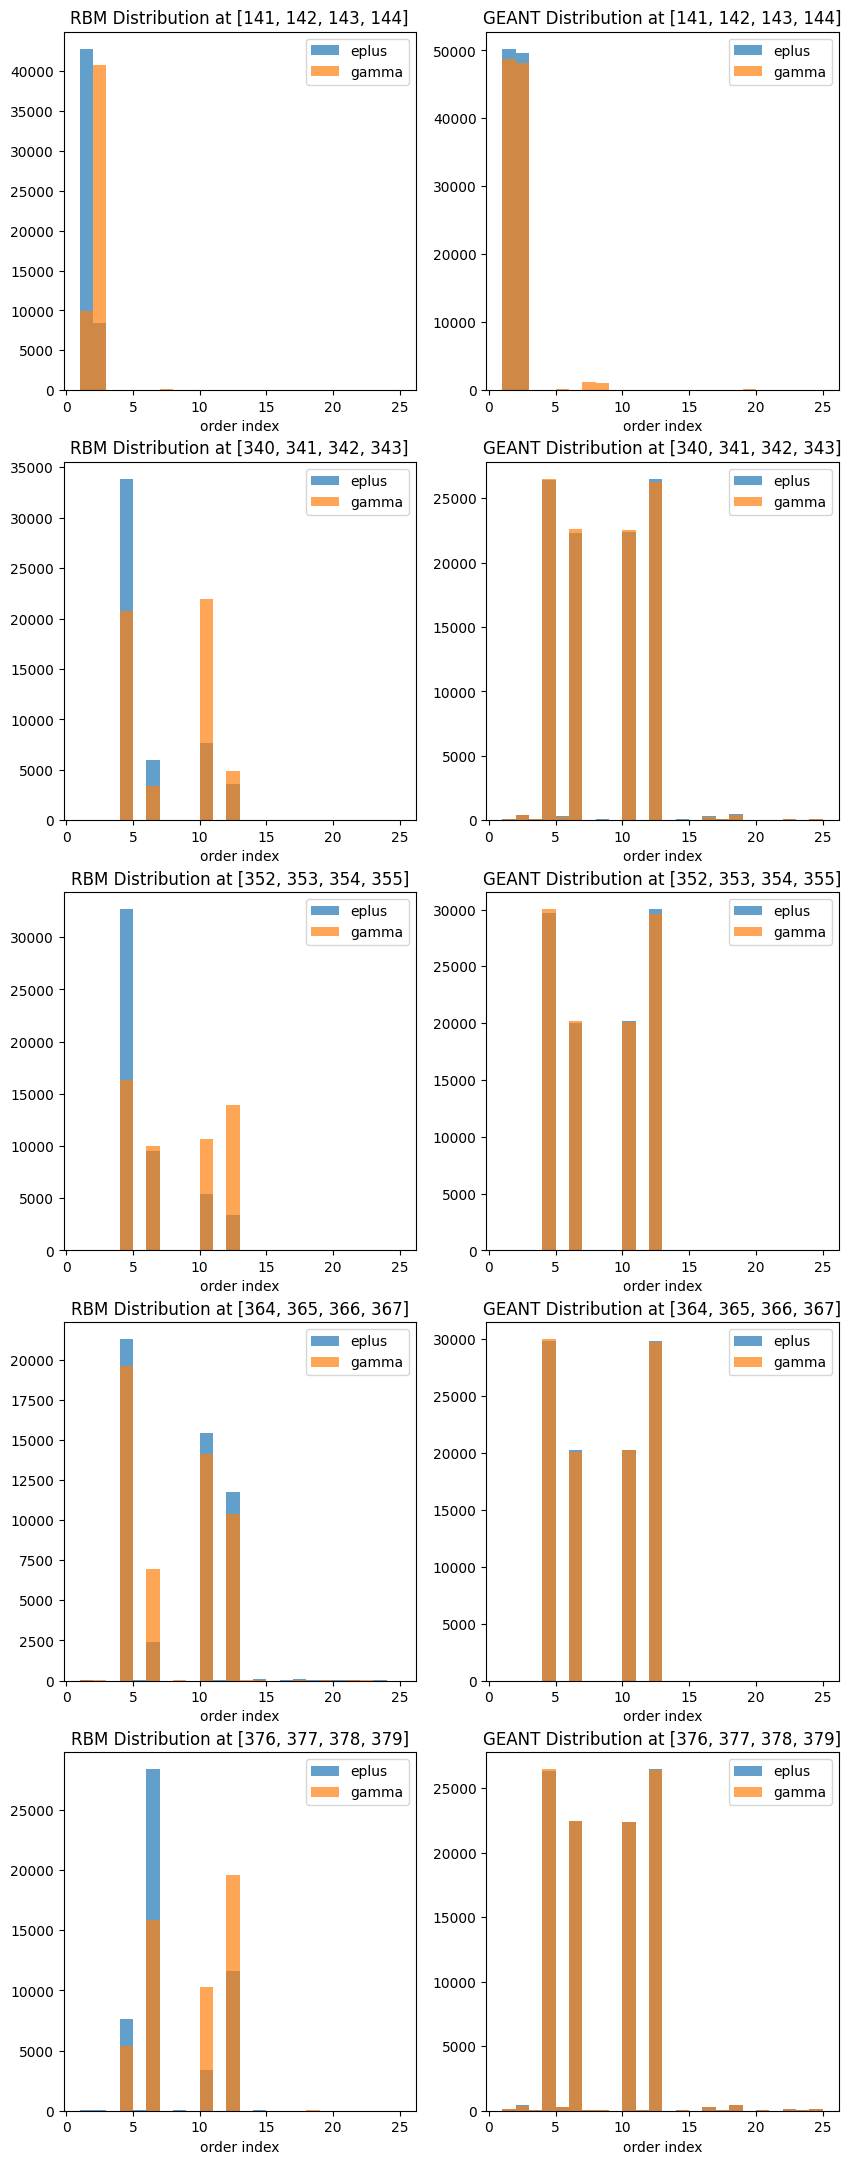

In [7]:

fig = plt.figure(figsize=(10, 27))
# Iterate through each subplot and plot the data
for i in range(1, 6):
    ax1 = fig.add_subplot(5, 2, 2*i-1)
    plot_orientation_diff(gamma_syn, eplus_syn, picked_lists[i-1], 'RBM', ax1)
    ax2 = fig.add_subplot(5, 2, 2*i)
    plot_orientation_diff(gamma_geant, eplus_geant, picked_lists[i-1], 'GEANT', ax2)